# Coder Pipeline
## General Setup

In [14]:
from coders import BitStream, WavStream, sync_padding
from coders import RMSQAM as Coder
from coders.util import rint, min_error
from coders.pipeline import Pipeline, ffmpeg
import scipy.io.wavfile
import warnings
warnings.filterwarnings('ignore')

coder = Coder()
coder.rate.set(96000)
coder.frequency.set(2700)
coder.symbol_duration.set(0.001)

ffmpeg = ffmpeg('ffmpeg')
noise_in = 0.1
noise_out = 0.1
sync_duration = 0.05

pipeline = Pipeline('.', noise_in=noise_in, noise_out=noise_out, sync_duration=sync_duration)

input_source = BitStream(np.random.randint(2, size=3000))

print('Coder ID:', id(coder))

Coder ID: 2570609842608


## Complete Run

In [15]:
%time pipeline_rate, pipeline_q = pipeline.test(coder, input_source)

Wall time: 427 ms


In [16]:
print('Pipeline rate:', round(pipeline_rate, 2), 'bps')
print('Pipeline quality:', round(pipeline_q, 2))

Pipeline rate: 3000.0 bps
Pipeline quality: 0.98


## Step-by-step Run with Demonstrations
### Prepare Verification

In [17]:
verification = input_source.assymbolwidth(coder.symbol_width.c)
print('Input:\n', verification)

Input:
 [2 6 7 4 7 3 6 2 6 2 2 2 5 4 3 7 4 2 4 0 4 2 6 0 2 2 3 6 1 3 4 3 2 6 7 7 5
 6 1 5 1 1 4 2 2 4 5 0 2 1 6 5 7 4 3 6 4 0 0 5 1 6 4 7 6 4 0 4 5 6 6 7 7 1
 4 0 1 0 4 5 4 4 2 6 2 1 2 0 6 5 1 2 6 0 2 3 1 6 5 4 4 3 4 2 6 1 5 7 6 3 4
 6 5 0 3 7 6 0 1 6 7 5 1 0 1 4 2 5 7 4 1 2 7 4 3 3 1 7 2 4 5 4 1 7 6 6 3 5
 5 0 2 4 7 0 7 0 7 6 7 4 4 5 2 3 7 5 5 2 5 5 0 4 0 2 6 7 3 4 5 4 7 4 2 2 0
 3 4 3 2 0 5 1 7 3 1 6 5 0 4 0 2 6 6 4 2 4 6 3 3 4 3 6 6 7 5 1 0 0 3 2 5 2
 1 2 7 6 2 6 3 3 0 5 1 2 2 3 3 1 1 2 6 0 7 7 1 3 0 5 1 5 0 4 0 6 7 6 5 1 7
 0 3 7 4 1 0 3 5 0 1 5 5 7 0 6 4 6 4 1 1 3 1 4 0 6 1 2 2 0 1 1 7 1 1 0 0 6
 1 4 1 1 3 0 7 2 7 6 6 3 7 7 5 4 2 2 1 5 6 0 6 1 0 7 4 1 0 6 4 0 2 6 7 5 5
 3 0 0 5 4 6 5 2 3 7 7 1 7 1 5 0 0 5 2 1 5 1 2 0 0 7 7 4 7 0 0 0 0 0 6 7 4
 3 5 0 0 5 0 3 4 7 0 4 5 3 6 6 1 0 0 5 0 3 4 2 6 5 3 3 4 5 3 6 6 1 0 0 4 7
 7 3 1 3 4 2 2 1 1 5 0 3 0 4 4 5 5 3 4 2 2 4 1 0 5 6 1 7 5 3 6 4 3 1 3 1 1
 2 4 2 2 4 5 7 2 6 5 7 5 5 1 3 5 1 5 0 7 0 4 5 2 4 1 0 5 4 4 1 3 0 4 5 4 3
 6 5 2 6 7 1 0 7 

### Encode and Noise

In [18]:
encoded = coder.encode(input_source)
sync = sync_padding(coder, sync_duration)
padded = np.concatenate((sync, encoded))
padded_noisy = np.clip(padded + np.random.normal(0, noise_in, len(padded)), -1, 1)
scipy.io.wavfile.write('test_in.wav', coder.r, padded_noisy)
ffmpeg('test_in.wav', 'test_temp.amr', 8000)
ffmpeg('test_temp.amr', 'test_out.wav', coder.r)
converted_rate, converted_raw = scipy.io.wavfile.read('test_out.wav')
converted_symbol_len = rint(converted_rate * coder.symbol_duration.c)
converted = converted_raw / 32768
converted_noisy = np.clip(converted + np.random.normal(0, noise_out, len(converted)), -1, 1)

### Sync with Original

In [19]:
shift = rint(0.005 * coder.rate.c)
if shift is None:
    shift = (len(converted) - len(padded)) // 2
shifted = WavStream(converted_noisy[shift:len(padded)+shift], converted_rate, converted_symbol_len)
print('Shifted:', shift)

sync_padding = rint(sync_duration * converted_rate)
sync_clip = sync_padding // 10
sync_shift = shift + min_error(padded, coder.filter(shifted), shift, sync_padding, sync_clip)
print('Filter shift:', sync_shift)

synced = WavStream(converted_noisy[shift+sync_padding:len(encoded)+shift+sync_padding], converted_rate, converted_symbol_len)
synced_clean = WavStream(converted[shift+sync_padding:len(encoded)+shift+sync_padding], converted_rate, converted_symbol_len)
synced_f = WavStream(converted_noisy[sync_shift+sync_padding:len(encoded)+sync_shift+sync_padding],
                     converted_rate, converted_symbol_len)
synced_f_clean = WavStream(converted[sync_shift+sync_padding:len(encoded)+sync_shift+sync_padding],
                     converted_rate, converted_symbol_len)

Shifted: 480
Filter shift: 515


### Decode

In [20]:
src = synced
src_clean = synced_clean

In [21]:
%time output, certainties = coder.decode(src, retcert=True)

Wall time: 218 ms


In [22]:
o = [s for s in encoded.symbols()]
s = [s for s in synced.symbols()]
sf = [s for s in synced_f.symbols()]

In [23]:
drb = verification == output

In [24]:
len(output) - drb.sum()

BitStream(35, symbolwidth=3)

Symbol: 1
Input: 6
Output: 2
Peaks: [  3.  24.  42.  59.  73.]
[ 0.9         3.92699082]
[ 0.45        3.14159265]
0.24954330602 3.92699081699


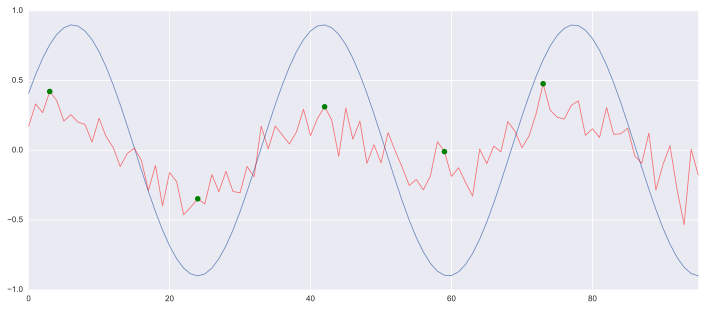

Symbol: 2
Input: 7
Output: 3
Peaks: [  4.  28.  42.  59.  80.]
[ 0.9         5.49778714]
[ 0.45        4.71238898]
0.292309157388 5.30143760293


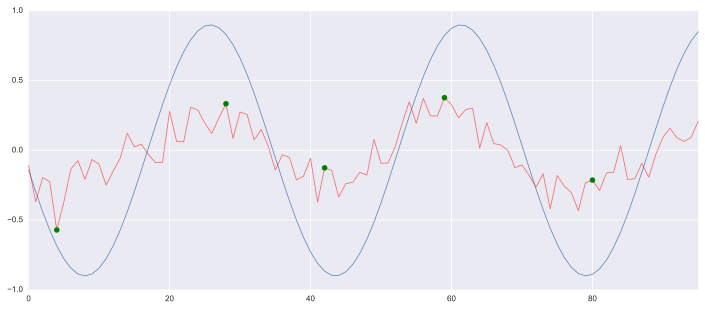

Symbol: 3
Input: 4
Output: 0
Peaks: [  8.  27.  45.  64.  78.]
[ 0.9         0.78539816]
[ 0.45  0.  ]
0.374268760535 0.785398163397


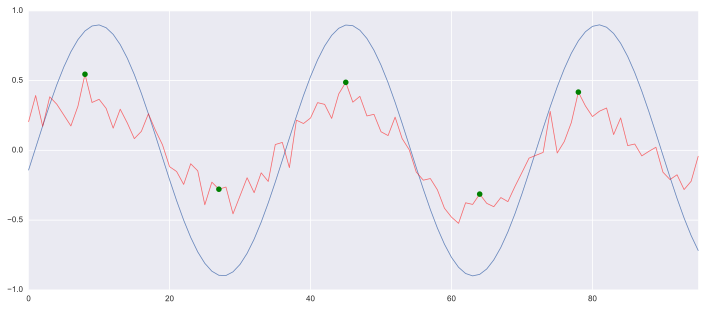

Symbol: 4
Input: 7
Output: 0
Peaks: [ 13.  29.  45.  66.  84.]
[ 0.9         5.49778714]
[ 0.45  0.  ]
0.327666568703 5.30143760293


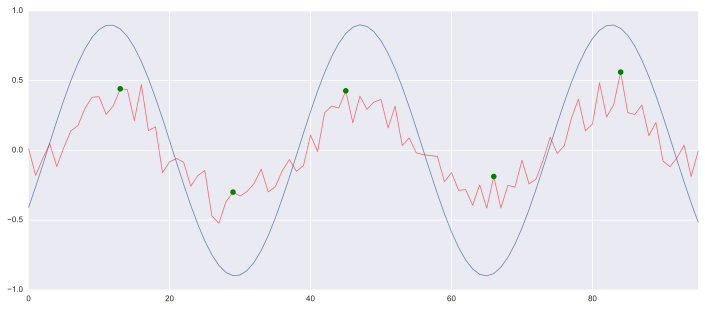

Symbol: 32
Input: 2
Output: 1
Peaks: [ 17.  27.  46.  60.  77.]
[ 0.45        3.14159265]
[ 0.45        1.57079633]
0.374832168356 2.55254403104


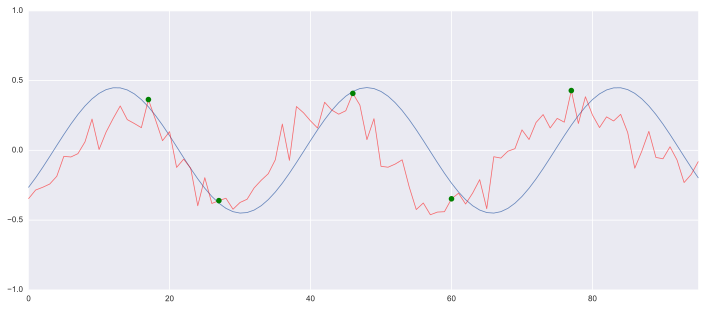

Symbol: 35
Input: 7
Output: 3
Peaks: [ 24.  41.  58.  74.]
[ 0.9         5.49778714]
[ 0.45        4.71238898]
0.568073046669 5.49778714378


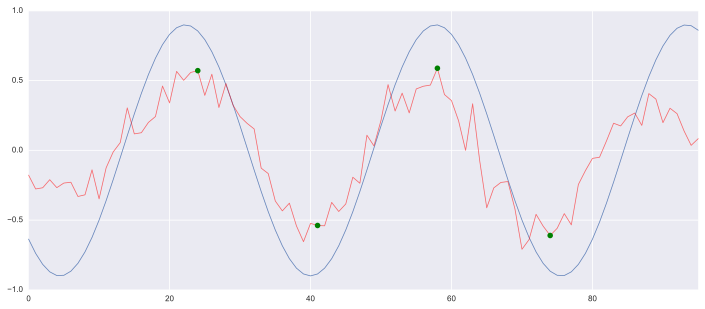

Symbol: 55
Input: 6
Output: 3
Peaks: [ 12.  32.  45.  70.  90.]
[ 0.9         3.92699082]
[ 0.45        4.71238898]
0.588184086848 3.92699081699


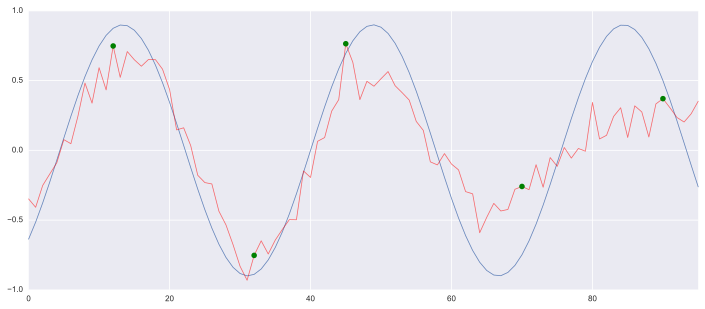

Symbol: 80
Input: 4
Output: 0
Peaks: [ 18.  34.  52.  66.  85.]
[ 0.9         0.78539816]
[ 0.45  0.  ]
0.524213257938 1.1780972451


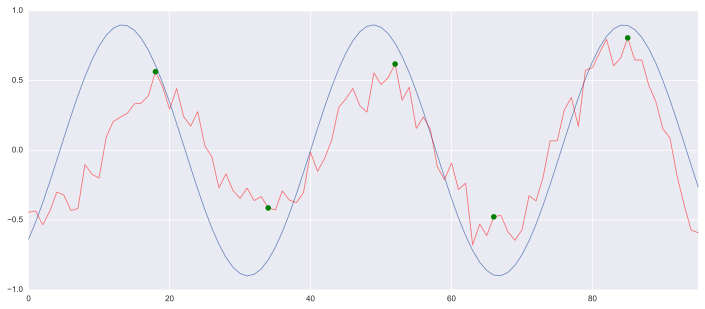

Symbol: 143
Input: 7
Output: 0
Peaks: [ 20.  39.  54.  70.]
[ 0.9         5.49778714]
[ 0.45  0.  ]
0.635431764986 5.69413668463


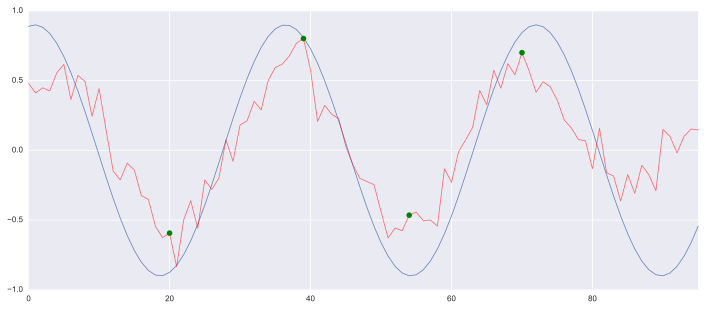

Symbol: 144
Input: 6
Output: 2
Peaks: [ 16.  35.  54.  74.  94.]
[ 0.9         3.92699082]
[ 0.45        3.14159265]
0.669999042556 3.53429173529


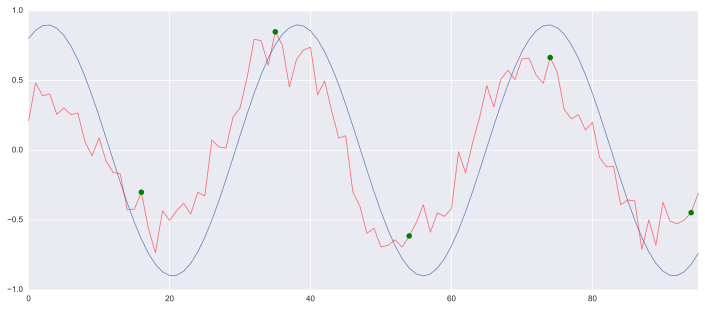

In [25]:
from coders import sq_cyclic_align_error, trim_mean

counter = 10
prev = -1
name = type(coder).__name__

for k, v in enumerate(drb):
    if not v and k != prev:
        prev = k
        λ = s[k].rate / coder.f
        symbol_len = rint(synced_f.rate * coder.symbol_duration.c)
    
        theoretical = verification[k]
        practical = output[k]
    
        print('Symbol:', k)
        print('Input:', theoretical)
        print('Output:', practical)
        
        shift2 = λ - (k * coder.symbol_len) % λ
        
        peaks = np.array(s[k].peaks(coder.peak_range, coder.peak_threshold.c))
        print('Peaks:', peaks[:, 0])
        
        amp = trim_mean(np.abs(peaks[:, 1]))
        
        positives = peaks[:, 0][peaks[:, 1] > 0] - shift2
        negatives = peaks[:, 0][peaks[:, 1] < 0] - shift2
        
        if 'QAM' in name or 'PSK' in name:
            if peaks[0, 1] == 0:
                del peaks_[0, 1]
            if peaks[-1, 1] == symbol_len - 1:
                del peaks[-1]

        if 'QAM' in name:
            n_shifts = coder.symbol_shifts.c * 2 * coder.d_symbol_shifts_scale.c
            shifts = sq_cyclic_align_error(positives, negatives, λ, n_shifts)
            shift = shifts.argmin() * coder.shift_step / coder.d_symbol_shifts_scale.c
            print(coder.polar[theoretical])
            print(coder.polar[practical])
            print(amp, shift)
        elif 'PSK' in name:
            print(k, sq_cyclic_align_error(positives, negatives, λ, coder.symbol_size))
        
        sns.tsplot(o[k], alpha=.8)
        p = sns.tsplot(s[k], color='r', alpha=.5)
        plt.plot(*peaks.T, marker='o', color='g', ls='') 
        axes = p.axes
        axes.set_ylim([-1, 1])
        
        plt.savefig('out/{}_error_{}_{}.pdf'.format(type(coder).__name__, k, id(coder)), bbox_inches='tight', pad_inches=0)
        plt.show()
        
        counter -= 1
        if not counter:
            break

### Verify and Plot

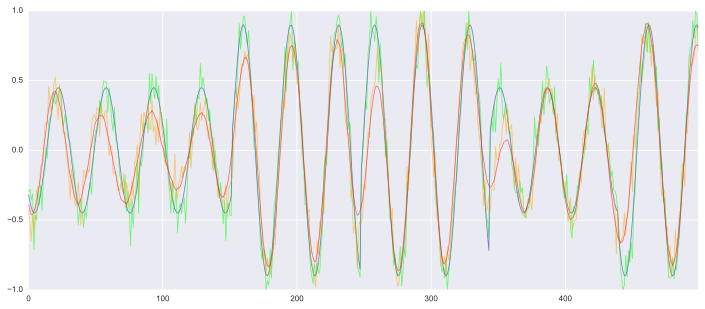

Rate: 3000.0 bps
Quality: 0.98
SNR1: 14.11 dB
SNR2: 12.67 dB
SNR3: 6.77 dB


In [26]:
check = input_source == output.assymbolwidth(1)
quality = (check.sum() / len(check)).item()
rate = len(check) / synced.duration

start, end = 0, 200
start, end = 1000, 1500
snr1 = 10 * np.log10(np.square(padded).sum() / np.square(padded - padded_noisy).sum()).item()
snr2 = 10 * np.log10(np.square(src_clean).sum() / np.square(src_clean - src).sum()).item()
snr3 = 10 * np.log10(np.square(encoded).sum() / np.square(encoded - src).sum()).item()
sns.tsplot(padded_noisy[len(sync)+start:len(sync)+end], color='lime', alpha=.5)
sns.tsplot(encoded[start:end], alpha=.8)
sns.tsplot(synced[start:end], color='orange', alpha=.5)
sns.tsplot(coder.filter(synced)[start:end], color='r', alpha=.5)
plt.savefig('out/{}_{}.pdf'.format(type(coder).__name__, id(coder)), bbox_inches='tight', pad_inches=0)
plt.show()
print('Rate:', round(rate, 2), 'bps')
print('Quality:', round(quality, 2))
print('SNR1:', round(snr1, 2), 'dB')
print('SNR2:', round(snr2, 2), 'dB')
print('SNR3:', round(snr3, 2), 'dB')